In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [4]:
class State(TypedDict):
    #messages have the type "list". The "add_messages" function
    #in the annotation defines how this state key should be updated
    #(in this case, it appends messages to the list, rather than overwriting them)

    messages:Annotated[list,add_messages]

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="llama3-8b-8192")

In [7]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A910522790>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A9108654D0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
llm = init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A910893190>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A910893610>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [18]:
# Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [20]:
graph_builder = StateGraph(State)

# Adding node
graph_builder.add_node("llmchatbot", chatbot)

# Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

# compile the graph
graph= graph_builder.compile()


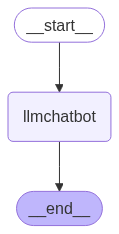

In [21]:
graph

In [22]:
response = graph.invoke({"messages":"Hii"})

In [23]:
response

{'messages': [HumanMessage(content='Hii', additional_kwargs={}, response_metadata={}, id='8377724d-9238-46aa-9117-eecf67d01240'),
  AIMessage(content='Hii! How are you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 12, 'total_tokens': 21, 'completion_time': 0.026379698, 'prompt_time': 0.006538736, 'queue_time': 0.26679457300000003, 'total_time': 0.032918434}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--4c3988cd-7628-47c0-a20f-a3e69866ee15-0', usage_metadata={'input_tokens': 12, 'output_tokens': 9, 'total_tokens': 21})]}

In [25]:
response["messages"][-1].content

'Hii! How are you today?'

In [26]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm just an AI, I don't have feelings or emotions like humans do, so I don't have a good or bad day. I'm just here to help answer your questions and provide information to the best of my ability! How can I assist you today?


#Chatbot with tool

In [27]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=3)
tool.invoke("what is Bank of baroda")

{'query': 'what is Bank of baroda',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Bank of Baroda - Wikipedia',
   'url': 'https://en.wikipedia.org/wiki/Bank_of_Baroda',
   'content': 'Bank of Baroda (BOB or BoB) is an Indian government Public sector bank headquartered in Vadodara, Gujarat. It is the third largest public sector bank in India after State Bank of India.',
   'score': 0.9467988,
   'raw_content': None},
  {'title': 'What is Brief History of Bank of Baroda Company?',
   'url': 'https://canvasbusinessmodel.com/blogs/brief-history/bank-of-baroda-brief-history',
   'content': "The Bank of Baroda, one of India's oldest and most respected financial institutions, has a rich history dating back to 1908. Founded by the Maharaja of Baroda, Sir Sayajirao Gaekwad III, the bank has grown from its humble beginnings in Baroda to become a global presence with a wide range of financial services. With a legacy of innovation and customer-centric approa

In [28]:
# custom function

def addition(a:int,b:int):
    """Add a and b
    Args:
    a(int): first int
    b(int): second int
    Returns:
    int: output int"""
    return a+b

In [29]:
tools = [tool,addition]

In [30]:
llm_with_tool= llm.bind_tools(tools)


In [40]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A910893190>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A910893610>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

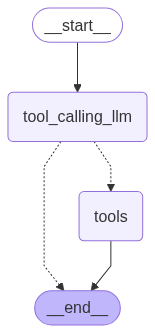

In [41]:
#  Stategraph

from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [44]:
response = graph.invoke({"messages":"What is the recent repo rate of RBI?"})

In [45]:
response['messages'][-1].content

'{"query": "recent repo rate of RBI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.wsj.com/articles/india-central-bank-delivers-larger-than-expected-rate-cut-to-support-growth-758de28c?gaa_at=eafs&gaa_n=ASWzDAjlGqkWAdp3hMSXiWx182gH3dsjkRCQZUsUO9c-xVl1tF_NjVGo2vGO&gaa_ts=6863f1f3&gaa_sig=BKAhxOL90LF-IKxCfL8BqGp82o8i_l7OGO4TD6hRV2xzk_Yj7Q8_BID4LgqrHeYqMhFVWeMoFgvN-IUrqlFjew%3D%3D", "title": "India Central Bank Delivers Larger-Than-Expected Rate ...", "content": "The Reserve Bank of India\'s monetary policy committee voted Friday to lower the benchmark repo rate to 5.50% from 6.00%, delivering a deeper cut", "score": 0.5971152, "raw_content": null}, {"url": "https://sg.finance.yahoo.com/news/india-cenbank-announces-reverse-repo-125248224.html", "title": "India cenbank announces reverse repo to arrest fall in ...", "content": "MUMBAI (Reuters) -India\'s central bank said on Tuesday it will conduct a seven-day variable rate reverse repo auction

In [49]:
response = graph.invoke({"messages": "what is 5 add 2 ?"})

In [48]:
response

{'messages': [HumanMessage(content='what is 5 add 2 ?', additional_kwargs={}, response_metadata={}, id='c757f112-0035-4f6e-9dc2-21bdf3edee02'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'y8j3wxcrr', 'function': {'arguments': '{"a":5,"b":2}', 'name': 'addition'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 2203, 'total_tokens': 2276, 'completion_time': 0.078032876, 'prompt_time': 0.244221239, 'queue_time': 0.274711559, 'total_time': 0.322254115}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--60aa4db8-a5d8-401a-b999-77fce4800192-0', tool_calls=[{'name': 'addition', 'args': {'a': 5, 'b': 2}, 'id': 'y8j3wxcrr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2203, 'output_tokens': 73, 'total_tokens': 2276}),
  ToolMessage(content='7', name='addition', id='3b56db55-59d6-4008-a73a-d4120838bcfc', tool_call_id='y8j3wxcrr')]}

In [50]:
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

what is 5 add 2 ?
================================== Ai Message ==================================
Tool Calls:
  addition (cn8mf4k0g)
 Call ID: cn8mf4k0g
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: addition

7


In [52]:
response = graph.invoke({"messages":"Give me the recent ai news and then 45 add 34"})
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then 45 add 34
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fsmzehwcf)
 Call ID: fsmzehwcf
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: week
  addition (n1zbf37y3)
 Call ID: n1zbf37y3
  Args:
    a: 45
    b: 34
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ptechpartners.com/2025/07/01/emerging-ai-news-roundup-for-may-and-june-2025-part-1-ai-agents-jobs-impact-and-the-return-of-the-surge/", "title": "Emerging AI News Roundup for May and June 2025 Part 1", "content": "Explore the biggest AI news from May and June 2025, including breakthroughs in AI agents, the evolving impact on jobs, and a renewed surge in 

# ReAct Agent Architecture

In LangGraph, a ReAct (Reasoning and Acting) agent architecture combines a Large Language Model (LLM) with the ability to reason, act, and observe its environment, enabling it to solve complex tasks and utilize external tools. The ReAct pattern allows the agent to dynamically adjust its approach based on new information and results from previous steps, similar to how humans solve problems. Here's a breakdown of the key concepts:

ReAct Framework: Reasoning: The LLM uses its reasoning capabilities to determine the next course of action. Acting: The agent can call tools, such as web searches or APIs, to gather information or perform actions. Observing: The agent analyzes the results of its actions to refine its reasoning and determine the next step.
LangGraph Implementation: Graph Structure: LangGraph uses a graph-based structure to represent the agent's workflow. Nodes in the graph represent different states or actions, and edges represent the transitions between them. State Management: The "state" feature in LangGraph acts as a memory bank, recording the agent's history and context throughout the process. Tool Calling: LangGraph provides tools for integrating various tools into the agent, including prebuilt LangChain tools like Wikipedia or DuckDuckGo, or custom-built tools. Conditional Edges: Edges can be conditional, allowing the agent to branch based on the results of previous steps and choose the appropriate next action.
How it Works: The agent starts with an initial input and a reasoning phase. The LLM generates a thought, an action, and potentially a tool call based on the input and current state. The agent executes the action, potentially using a tool. The agent observes the results and updates its state. The agent repeats the reasoning, acting, and observing cycle until it reaches a conclusion or a predefined stopping condition.

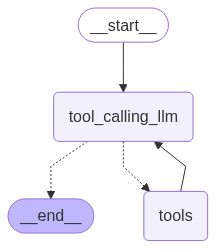

In [57]:
# Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

#Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

# Add Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)

builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))


# Adding Memory in Agentic Graph

In [58]:
response= graph.invoke({"messages":"Hello my name is Mukesh Yadav"})
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

Hello my name is Mukesh Yadav
================================== Ai Message ==================================

Nice to meet you, Mukesh!


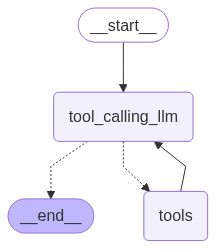

In [63]:
# Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [64]:
config={"configurable":{"thread_id":"1"}}
response= graph.invoke({"messages":"Hi my name is Mukesh Yadav"}, config= config)
response

{'messages': [HumanMessage(content='Hi my name is Mukesh Yadav', additional_kwargs={}, response_metadata={}, id='1351b54d-b44f-47c4-abd2-b010fd3fb9e5'),
  AIMessage(content='Nice to meet you, Mukesh Yadav!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 4425, 'total_tokens': 4436, 'completion_time': 0.009431073, 'prompt_time': 0.491991189, 'queue_time': -0.585290355, 'total_time': 0.501422262}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--c0ac89b0-e9d5-458c-ac55-0e79834d0985-0', usage_metadata={'input_tokens': 4425, 'output_tokens': 11, 'total_tokens': 4436})]}

In [65]:
response['messages'][-1].content

'Nice to meet you, Mukesh Yadav!'

In [66]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)
print(response['messages'][-1].content)

Your name is Mukesh Yadav.


In [67]:
response = graph.invoke({'messages':"He do you remember my name"},config=config)
print(response['messages'][-1].content)

I remember your name is Mukesh Yadav.


# Streaming

In [68]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [69]:
def superbot(state:State):
    return{"messages":[llm.invoke(state['messages'])]}

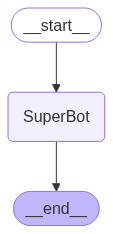

In [70]:
graph = StateGraph(State)

# node
graph.add_node("SuperBot",superbot)

#Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)

graph_builder=graph.compile(checkpointer=memory)

# Display 
from IPython.display import Image,display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [71]:
# Invocation

config = {"configurable": {"thread_id":"1"}}

graph_builder.invoke({'messages':"Hii, My name is Mukesh Yadav and I like to coding"},config)

{'messages': [HumanMessage(content='Hii, My name is Mukesh Yadav and I like to coding', additional_kwargs={}, response_metadata={}, id='58d89555-0af5-4657-82de-7b40b318c004'),
  AIMessage(content="Hello Mukesh Yadav! Nice to meet you! It's great to hear that you like coding. What kind of programming languages or technologies are you interested in? Are you a beginner or do you have some experience with coding?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 25, 'total_tokens': 72, 'completion_time': 0.142661718, 'prompt_time': 0.009833013, 'queue_time': 0.26648552799999997, 'total_time': 0.152494731}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--dfe4517b-0396-417c-9e4b-2b17287cc292-0', usage_metadata={'input_tokens': 25, 'output_tokens': 47, 'total_tokens': 72})]}

Streaming Methods: stream() and astream()

These methods are sync methods for streaming back results.
Additional parameters in streaming modes for graph state
values: This streams the full state of the graph after each mode is called.
updates: This streams updates to the state of the graph after each node is called.

In [72]:
# Create a thread

config = {"configurable":{'thread_id':"3"}}

for chunk in graph_builder.stream({'messages':" Hi, I also like to play cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="That's great! Cricket is a fantastic sport, isn't it? What's your favorite part about playing or watching cricket? Are you a fan of a particular team or player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 18, 'total_tokens': 55, 'completion_time': 0.025657634, 'prompt_time': 0.002399922, 'queue_time': 0.271196278, 'total_time': 0.028057556}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_2717d04279', 'finish_reason': 'stop', 'logprobs': None}, id='run--c5df0eb6-157b-4935-aa74-25bde6156b85-0', usage_metadata={'input_tokens': 18, 'output_tokens': 37, 'total_tokens': 55})]}}
